Tutorial 2: Mappers

In the previous example, we made a Mapper from a rectangular Pixelization. However, it wasn’t clear what a Mapper was actually mapping. Infact, it didn’t do much mapping at all! Therefore, in this tutorial, we’ll cover mapping.

In [1]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt
from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/autolens_workspace


We’ll use new strong lensing data, where:

    The lens galaxy’s light is omitted.
    The lens galaxy’s MassProfile is an PointMass2.
    The source galaxy’s LightProfile is an EllipticalSersic.


In [2]:
dataset_path = f"{workspace_path}/howtolens/PointMass2/Data"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/image.fits",
    noise_map_path=f"{dataset_path}/noise_map.fits",
    psf_path=f"{dataset_path}/psf.fits",
    pixel_scales=0.1,
)


Now, lets set up our Grid’s (using the image above).

In [3]:
grid = al.Grid.uniform(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, sub_size=1
)

Our Tracer will use the same lens galaxy and source galaxy that we used to Simulate the Imaging data (although, becuase we’re modeling the source with a pixel-grid, we don’t need to supply its LightProfile).

In [5]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.PointMass2(
        centre=(0.0, 0.0),einstein_radius=1.6
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=1.0)])

source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=grid)[1]


Next, we setup our _Pixelization_and Mapper using the tracer’s source-plane grid.

In [6]:
rectangular = al.pix.Rectangular(shape=(25, 25))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

We’re going to plot our Mapper alongside the image we used to generate the source-plane grid.

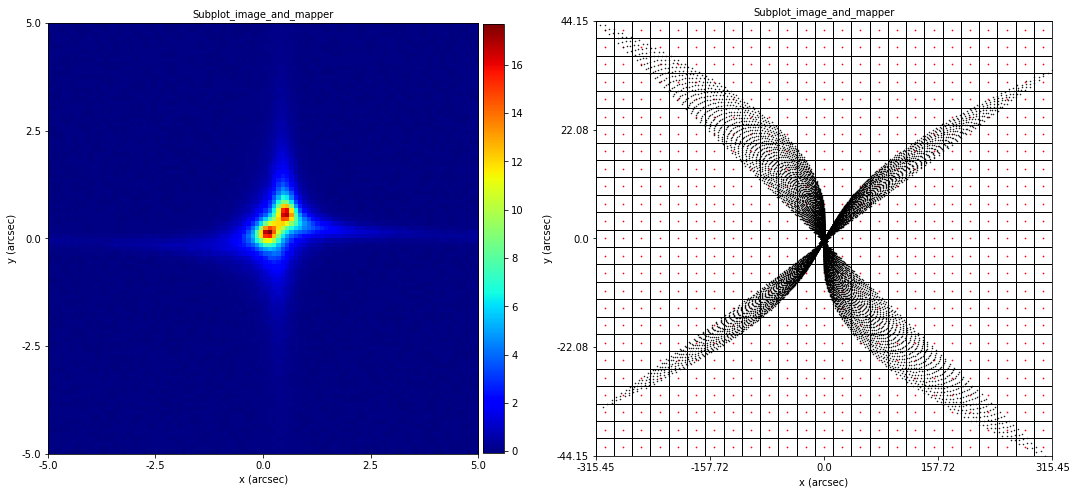

In [7]:
aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image, mapper=mapper, include=aplt.Include(inversion_grid=True)
)

The pixels in the image map to the pixels in the source-plane, and visa-versa. Lets highlight a set of image-pixels in both the image and source-plane.

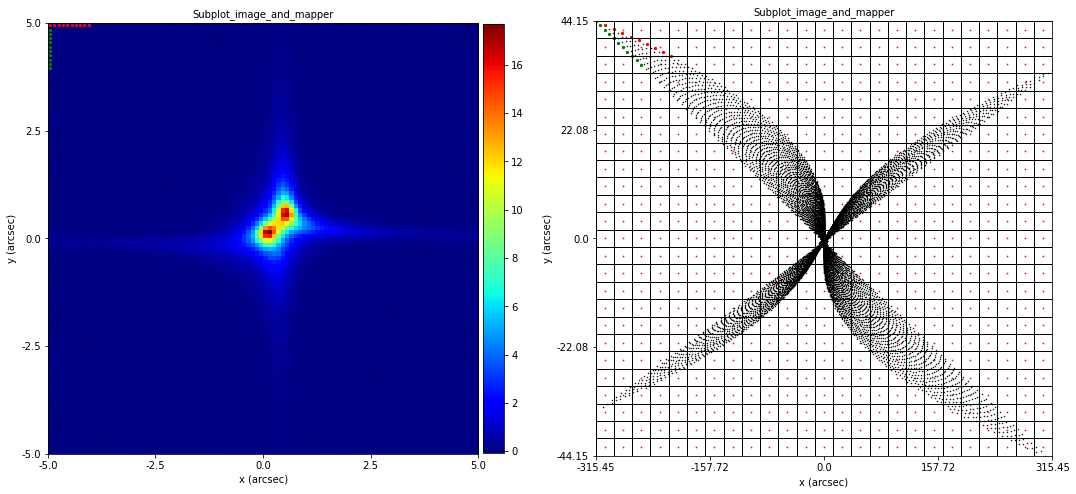

In [8]:
aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(inversion_grid=True),
    image_pixel_indexes=[
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    ],
)

That’s nice, and we can see the mappings, but it isn’t really what we want to know, is it? We really want to go the other way, and see how our source-pixels map to the image. This is where Mapper’s come into their own, as they let us map all the points in a given source-pixel back to the image. Lets map source pixel 313, the central source-pixel, to the image.

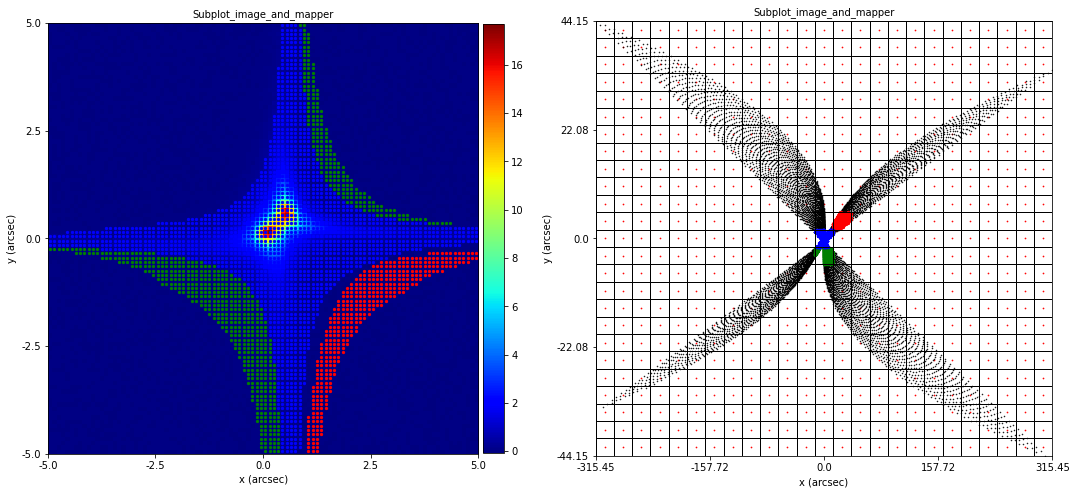

In [23]:
aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(inversion_grid=True),
    source_pixel_indexes=[[288], [337], [312]],
)

Finally, lets do the same as above, but using a masked image. By applying a Mask, the Mapper will only map image-pixels inside the mask. This removes the (many) image pixels at the edge of the image, where the source isn’t present. These pixels also pad-out the source-plane, thus by removing them our source-plane reduces in size.

Lets just have a quick look at these edges pixels:

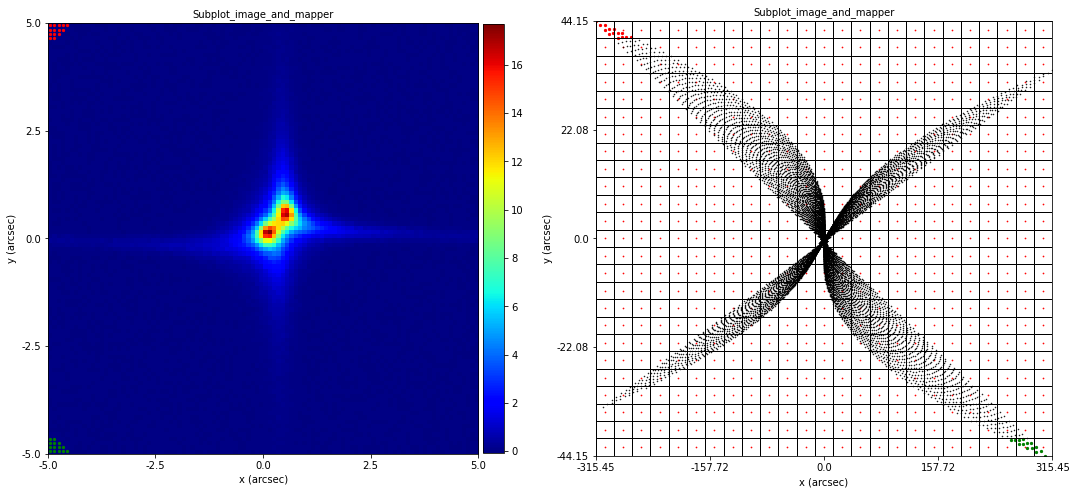

In [24]:
aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(inversion_grid=True),
    source_pixel_indexes=[[0, 1, 2, 3, 4, 5, 6, 7], [620, 621, 622, 623, 624]],
)

Lets use an circular Mask, which will capture the ring-like shape of the lensed source galaxy.

In [32]:
mask = al.Mask.circular(
    shape_2d=imaging.shape_2d,
    pixel_scales=imaging.pixel_scales,
    radius=3.,
)

Lets quickly confirm the annuli capture the source’s light.

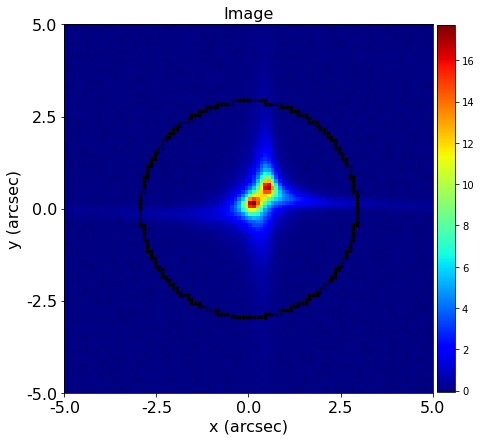

In [33]:
aplt.Imaging.image(imaging=imaging, mask=mask)

As usual, we setup our Imaging and Mask up as a MaskedImaging object and create a Tracer using the (masked) grid.

In [34]:
masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=1.0)])

source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]


Finally, we use the masked source-plane Grid to setup a new Mapper (using the same rectangular 25 x 25 Pixelization as before).

In [36]:
mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

/home/carlos/anaconda3/lib/python3.7/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'grid_1d_indexes' of function 'furthest_grid_1d_index_from'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../anaconda3/lib/python3.7/site-packages/autoarray/util/grid_util.py", line 536:
@decorator_util.jit()
def furthest_grid_1d_index_from(grid_1d, grid_1d_indexes, coordinate):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


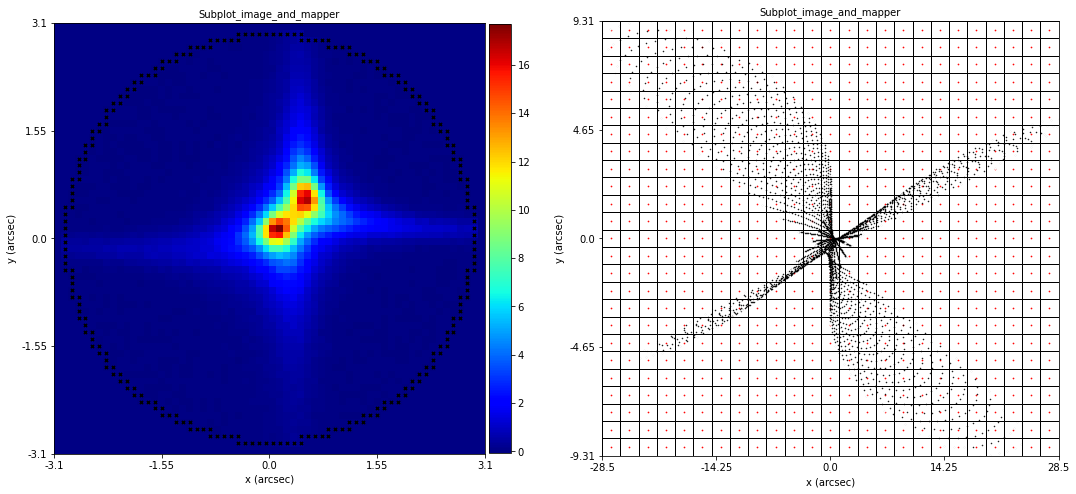

In [37]:
aplt.Mapper.subplot_image_and_mapper(
    image=masked_imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=True, inversion_grid=True),
)



Woah! Look how much closer we are to the source-plane. We can now really see the diamond of points in the centre of the source-plane (for those who have been reading up, this diamond is called the ‘caustic’). 

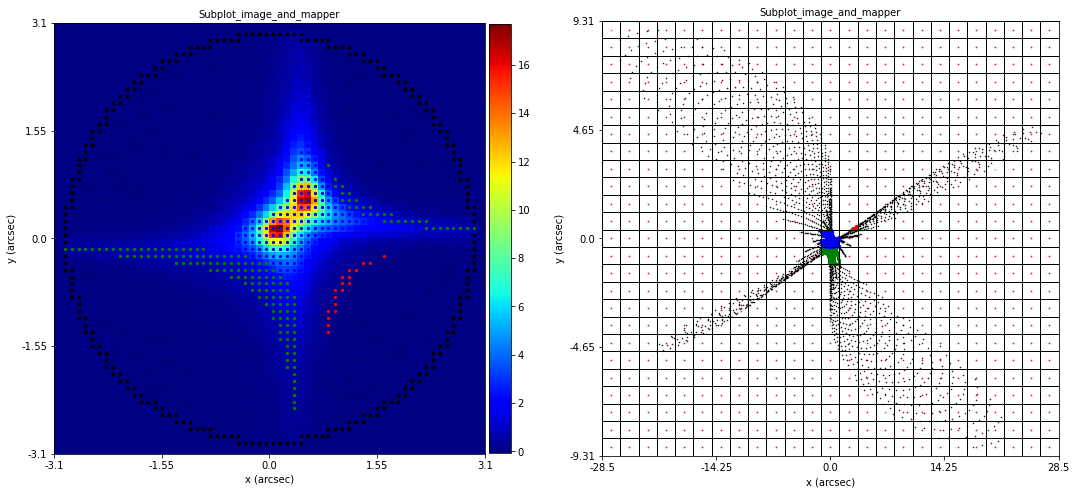

In [39]:
aplt.Mapper.subplot_image_and_mapper(
    image=masked_imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=True, inversion_grid=True),
    source_pixel_indexes=[[288], [337], [312]],
)

Great - tutorial 2 down! We’ve learnt about Mapper’s, which map things, and we used them to understand how the image and source plane map to one another.